In [2]:

import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import cv2
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


from tqdm import tqdm


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
DATA_DIR = "/kaggle/input/aptos2019"

train_df = pd.read_csv(os.path.join(DATA_DIR, "train_1.csv"))
val_df   = pd.read_csv(os.path.join(DATA_DIR, "valid.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print(train_df.head())
print(val_df.head())
print(test_df.head())

        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
        id_code  diagnosis
0  e4dcca36ceb4          0
1  e4e343eaae2a          2
2  e4f12411fd85          4
3  e50b0174690d          0
4  e5197d77ec68          0


In [4]:
train_df['diagnosis'].unique()

array([2, 1, 4, 0, 3])

In [5]:

# For training images (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # fixed size for CNN
    transforms.RandomHorizontalFlip(),       # augmentation
    transforms.RandomRotation(10),            # augmentation
    transforms.ToTensor(),                    # image → tensor
    transforms.Normalize(                     # normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# For validation / test images (NO augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:

class APTOSDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, "id_code"]
        label = self.df.loc[idx, "diagnosis"]

        img_path = os.path.join(self.img_dir, img_id + ".png")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
DATA_DIR = "/kaggle/input/aptos2019"

TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images", "train_images")
VAL_IMG_DIR   = os.path.join(DATA_DIR, "val_images", "val_images")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test_images", "test_images")

train_dataset = APTOSDataset(train_df, TRAIN_IMG_DIR, train_transforms)
val_dataset   = APTOSDataset(val_df, VAL_IMG_DIR, val_transforms)
test_dataset  = APTOSDataset(test_df, TEST_IMG_DIR, val_transforms)

In [8]:
img, label = train_dataset[0]

print(img.shape)
print(label)

torch.Size([3, 224, 224])
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


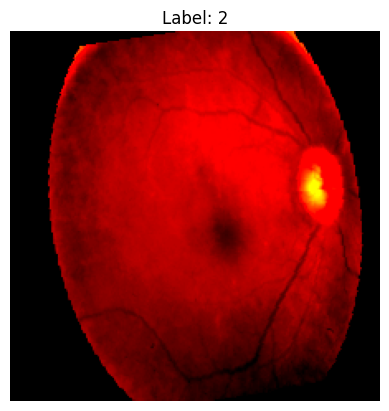

In [9]:
# Convert from (C, H, W) → (H, W, C)
img_np = img.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
model = models.resnet18(pretrained=True)

# Change final layer for 5 classes
model.fc = nn.Linear(model.fc.in_features, 5)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 248MB/s]


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)

In [ ]:
model.eval()

with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    output = model(img)
    _, predicted = torch.max(output, 1)

print("Predicted Class:", predicted.item())